In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [8]:
image_size = 224
batch_size = 32

train_data_dir = r"/kaggle/input/ocular-toxoplasmosis/BinaryClassification/BinaryClassification/train_augmented_20"
validation_data_dir = r"/kaggle/input/ocular-toxoplasmosis/BinaryClassification/BinaryClassification/val"

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical')
val_generator = validation_datagen.flow_from_directory( validation_data_dir, target_size=(image_size, image_size), batch_size=batch_size, 
                                                       class_mode='categorical', shuffle=False)

# Define the number of classes in your dataset
num_classes = train_generator.num_classes

# Calculate class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 5954 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
{0: 0.6962114125350796, 1: 1.7741358760429082}


In [9]:
l = []

def modelfunction(base):
    
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model 

def get_callbacks(weight):
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test, model_name):
    history = model.evaluate(generator_test)
    
    data = {}
    data['Model'] = model_name
    data['loss'] = history[0]
    data['accuracy'] = history[1]
    data['auc'] = history[2]
    data['precision'] = history[3]
    data['recall'] = history[4]
    data['f1_score'] = history[5]
    data['cohen_kappa'] = history[6]
    l.append(data)

    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())
    cr = classification_report(y_true, y_pred_classes)
    print(cr)
    cm = confusion_matrix(y_true, y_pred_classes)
    data['cm'] = cm
    data['cr'] = cr
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    
def model_training(base, weight, epochs):

    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")
    
    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics= metrics)

    history = model.fit(train_generator, steps_per_epoch=5954 // batch_size, epochs=epochs, callbacks=callbacks, 
                        validation_data= val_generator, class_weight = class_weights)
    
    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator, weight)
    
    return model 

# MobileNet

17225924/17225924 [==============================] - 0s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 2.0221 - accuracy: 0.7916 - auc_6: 0.8742 - precision_6: 0.7916 - recall_6: 0.7916 - cohen_kappa: -0.8343 - f1_score: 0.7709
Epoch 1: val_loss improved from inf to 2.05652, saving model to MobileNet.h5
186/186 [==============================] - 127s 588ms/step - loss: 2.0221 - accuracy: 0.7916 - auc_6: 0.8742 - precision_6: 0.7916 - recall_6: 0.7916 - cohen_kappa: -0.8343 - f1_score: 0.7709 - val_loss: 2.0565 - val_accuracy: 0.8267 - val_auc_6: 0.8786 - val_precision_6: 0.8267 - val_recall_6: 0.8267 - val_cohen_kappa: -0.5915 - val_f1_score: 0.7668 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 1.7625 - accuracy: 0.9267 - auc_6: 0.9773 - precision_6: 0.9267 - recall_6: 0.9267 - cohen_kappa: -0.7394 - f1_score: 0.9138
Epoch 2: val_loss did not improve

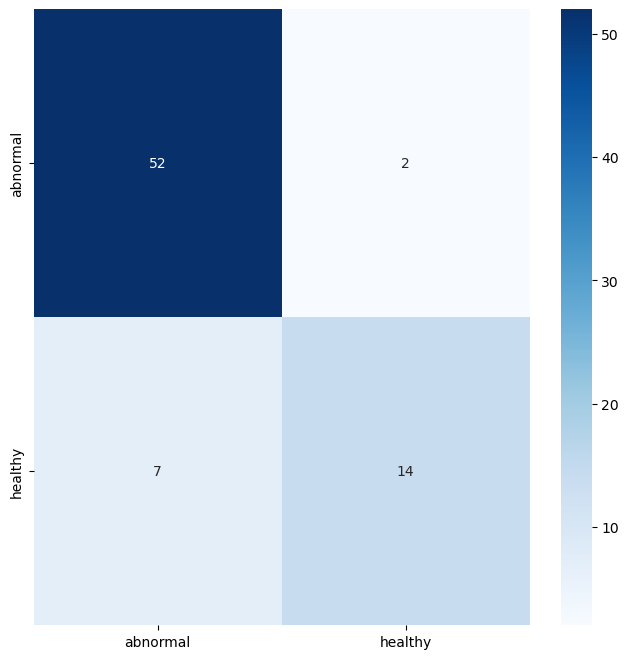

In [ ]:
MobileNet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

MobileNet_model = model_training(MobileNet,'MobileNet.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 1.4686 - accuracy: 0.9007 - auc_1: 0.9589 - precision_1: 0.9007 - recall_1: 0.9007 - cohen_kappa: -0.7390 - f1_score: 0.8832
Epoch 1: val_loss improved from inf to 3.58666, saving model to Vgg19.h5
186/186 [==============================] - 188s 690ms/step - loss: 1.4686 - accuracy: 0.9007 - auc_1: 0.9589 - precision_1: 0.9007 - recall_1: 0.9007 - cohen_kappa: -0.7390 - f1_score: 0.8832 - val_loss: 3.5867 - val_accuracy: 0.7333 - val_auc_1: 0.7698 - val_precision_1: 0.7333 - val_recall_1: 0.7333 - val_cohen_kappa: -0.3339 - val_f1_score: 0.4673 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.9843 - auc_1: 0.9982 - precision_1: 0.9843 - recall_1: 0.9843 - cohen_kappa: -0.6928 - f1_score: 0.9808
Epoch 2: val_loss improved from 3.58666 to 3.46587, saving model to Vgg19.h5
186/186 [================

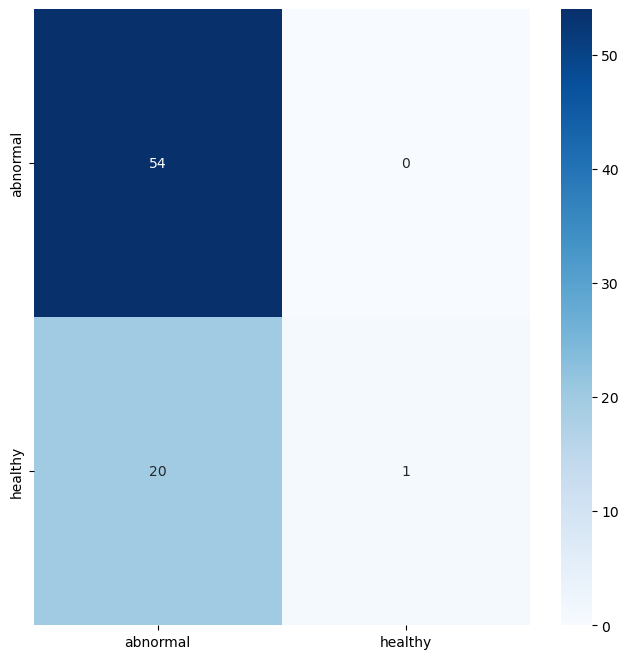

In [11]:
Vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg19 = model_training(Vgg19,'Vgg19.h5', 100)

83683744/83683744 [==============================] - 0s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 2.6898 - accuracy: 0.8002 - auc_2: 0.8895 - precision_2: 0.8002 - recall_2: 0.8002 - cohen_kappa: -0.8002 - f1_score: 0.7753
Epoch 1: val_loss improved from inf to 2.70611, saving model to Xception.h5
186/186 [==============================] - 160s 674ms/step - loss: 2.6898 - accuracy: 0.8002 - auc_2: 0.8895 - precision_2: 0.8002 - recall_2: 0.8002 - cohen_kappa: -0.8002 - f1_score: 0.7753 - val_loss: 2.7061 - val_accuracy: 0.7467 - val_auc_2: 0.8500 - val_precision_2: 0.7467 - val_recall_2: 0.7467 - val_cohen_kappa: -0.4188 - val_f1_score: 0.5709 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 2.2950 - accuracy: 0.9478 - auc_2: 0.9872 - precision_2: 0.9478 - recall_2: 0.9478 - cohen_kappa: -0.7245 - f1_score: 0.9379
Epoch 2: val_loss improved from 2.

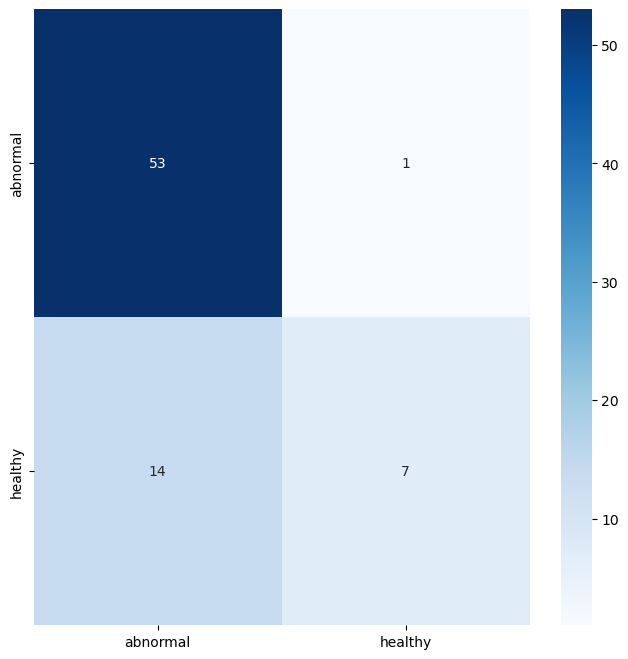

In [12]:
Xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Xception = model_training(Xception,'Xception.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 2.6281 - accuracy: 0.8259 - auc_3: 0.9103 - precision_3: 0.8259 - recall_3: 0.8259 - cohen_kappa: -0.8160 - f1_score: 0.8063
Epoch 1: val_loss improved from inf to 2.74334, saving model to InceptionV3.h5
186/186 [==============================] - 156s 630ms/step - loss: 2.6281 - accuracy: 0.8259 - auc_3: 0.9103 - precision_3: 0.8259 - recall_3: 0.8259 - cohen_kappa: -0.8160 - f1_score: 0.8063 - val_loss: 2.7433 - val_accuracy: 0.7333 - val_auc_3: 0.8553 - val_precision_3: 0.7333 - val_recall_3: 0.7333 - val_cohen_kappa: -0.4706 - val_f1_score: 0.5833 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 2.3247 - accuracy: 0.9620 - auc_3: 0.9906 - precision_3: 0.9620 - recall_3: 0.9620 - cohen_kappa: -0.7116 - f1_score: 0.9543
Epoch 2: val_loss improved from 2.74334 to 2.67597, saving model to InceptionV3.h5
186/186 [====

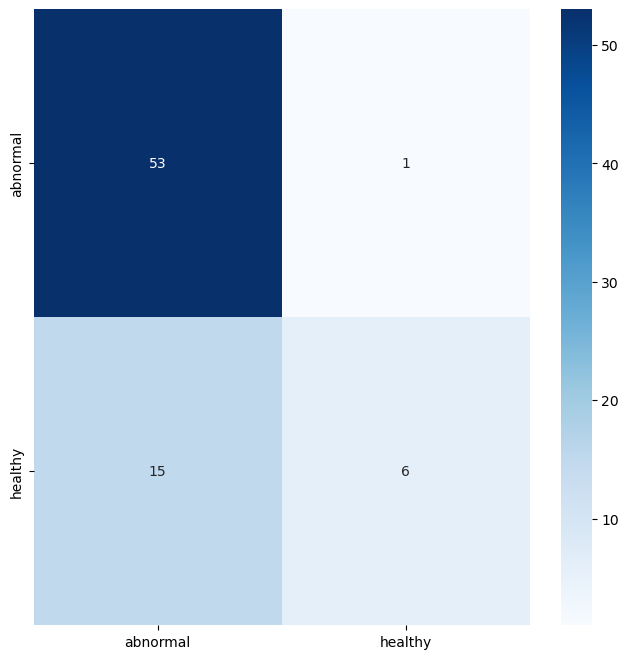

In [13]:
InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionV3 = model_training(InceptionV3,'InceptionV3.h5', 100)

29084464/29084464 [==============================] - 0s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 1.9689 - accuracy: 0.8235 - auc_4: 0.9043 - precision_4: 0.8235 - recall_4: 0.8235 - cohen_kappa: -0.7631 - f1_score: 0.7961
Epoch 1: val_loss improved from inf to 2.06518, saving model to DenseNet121.h5
186/186 [==============================] - 210s 702ms/step - loss: 1.9689 - accuracy: 0.8235 - auc_4: 0.9043 - precision_4: 0.8235 - recall_4: 0.8235 - cohen_kappa: -0.7631 - f1_score: 0.7961 - val_loss: 2.0652 - val_accuracy: 0.7200 - val_auc_4: 0.8424 - val_precision_4: 0.7200 - val_recall_4: 0.7200 - val_cohen_kappa: -0.5225 - val_f1_score: 0.5921 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.9446 - auc_4: 0.9845 - precision_4: 0.9446 - recall_4: 0.9446 - cohen_kappa: -0.7255 - f1_score: 0.9341
Epoch 2: val_loss improved from

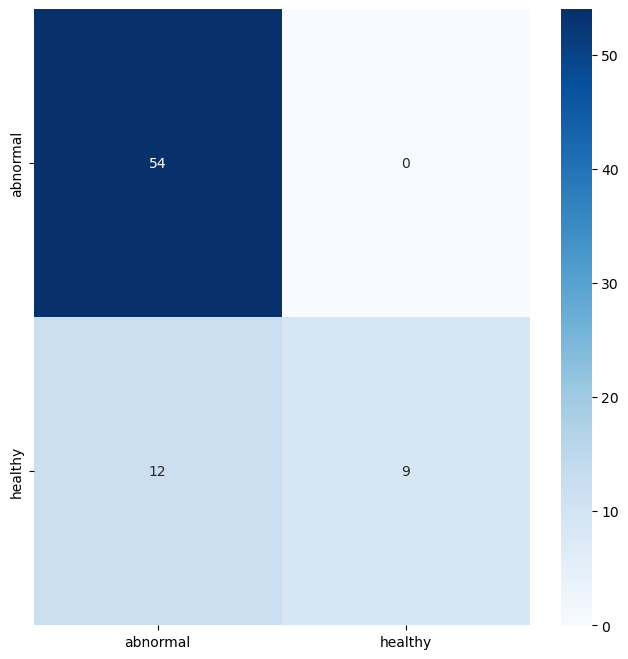

In [14]:
DenseNet121 = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

DenseNet121 = model_training(DenseNet121,'DenseNet121.h5', 100)

58889256/58889256 [==============================] - 0s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 1.4472 - accuracy: 0.8862 - auc_5: 0.9533 - precision_5: 0.8862 - recall_5: 0.8862 - cohen_kappa: -0.7387 - f1_score: 0.8661
Epoch 1: val_loss improved from inf to 2.82515, saving model to Vgg16.h5
186/186 [==============================] - 132s 676ms/step - loss: 1.4472 - accuracy: 0.8862 - auc_5: 0.9533 - precision_5: 0.8862 - recall_5: 0.8862 - cohen_kappa: -0.7387 - f1_score: 0.8661 - val_loss: 2.8251 - val_accuracy: 0.7600 - val_auc_5: 0.8091 - val_precision_5: 0.7600 - val_recall_5: 0.7600 - val_cohen_kappa: -0.4017 - val_f1_score: 0.5813 - lr: 1.0000e-05
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 1.1632 - accuracy: 0.9802 - auc_5: 0.9978 - precision_5: 0.9802 - recall_5: 0.9802 - cohen_kappa: -0.6965 - f1_score: 0.9759
Epoch 2: val_loss did not improve fro

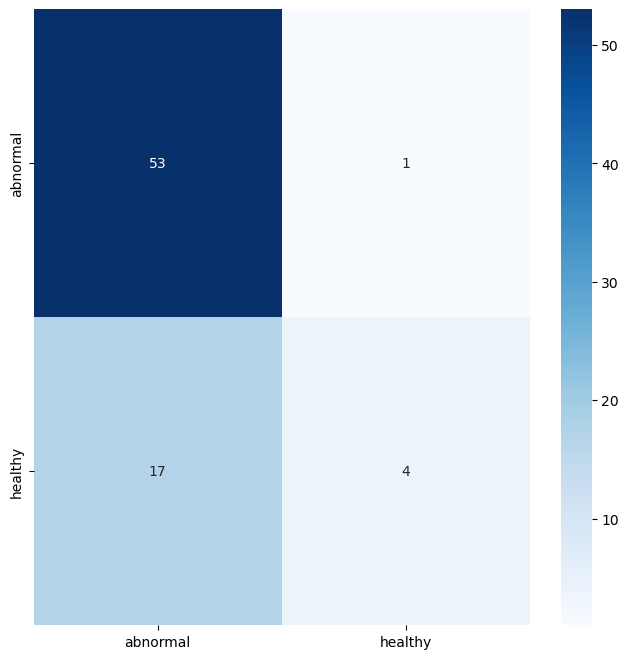

In [15]:
Vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg16 = model_training(Vgg16,'Vgg16.h5', 100)

In [ ]:
df = pd.DataFrame(l)
df

,Model,loss,accuracy,auc,precision,recall,f1_score,cohen_kappa,cm,cr
0,Vgg19.h5,3.465874,0.733333,0.798756,0.733333,0.733333,-0.333887,"[0.84375, 0.090909086]","[[54, 0], [20, 1]]",precision recall f1-score ...
1,Xception.h5,0.673971,0.800000,0.876978,0.800000,0.800000,-0.453301,"[0.87603307, 0.48275864]","[[53, 1], [14, 7]]",precision recall f1-score ...
2,InceptionV3.h5,0.621520,0.786667,0.904533,0.786667,0.786667,-0.436048,"[0.86885244, 0.42857143]","[[53, 1], [15, 6]]",precision recall f1-score ...
3,DenseNet121.h5,0.560996,0.840000,0.931911,0.840000,0.840000,-0.470588,"[0.90000004, 0.59999996]","[[54, 0], [12, 9]]",precision recall f1-score ...
4,Vgg16.h5,2.825145,0.760000,0.809067,0.760000,0.760000,-0.401694,"[0.8548387, 0.30769232]","[[53, 1], [17, 4]]",precision recall f1-score ...
5,MobileNet.h5,0.391046,0.880000,0.948800,0.880000,0.880000,-0.591456,"[0.92035407, 0.7567568]","[[52, 2], [7, 14]]",precision recall f1-score ...
